# Thesis Code Part 1: EDA

## Import Packages

In [14]:
# Import packages
import pandas as pd
import numpy as np
import re
import os
import pydicom as dcm
from PIL import Image
import matplotlib.pyplot as plt

## UCSF CXR Dataset EDA

In [3]:
# Read report data
data = pd.read_csv('/mnt/sohn2022/UCSF_secure_cxr_data/Secure_UCSF_CXR_01012022_to_02132023.csv',index_col=0)
data = data.iloc[:,:13]
data.head()

,Organization,Point of Care,Source System,Accession Number,Modality,Exam Code,Exam Description,CPT Code,Report Text,Is Stat,Patient Status,Patient Sex,Patient Age
0,MBXR1,RAD X-RAY MB,EPIC,10022207761,XR,DCHE2,XR CHEST 2 VIEWS PA AND LATERAL,71020,XR CHEST 2 VIEWS PA AND LATERAL 6/30/2022 11...,False,Emergency,Male,39.00
1,PDR11,RAD X-RAY PARN,EPIC,10022207760,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:53 PM\nHISTO...,False,Emergency,Male,41.00
2,PDR9,RAD X-RAY PARN,EPIC,10022207745,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:36 PM\nHISTO...,False,Inpatient,Female,25.00
3,PDR9,RAD X-RAY PARN,EPIC,10022207747,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:26 PM\nHISTO...,False,Inpatient,Female,60.00
4,MBP9,RAD X-RAY MB,EPIC,10022207748,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:21 PM\nINDIC...,False,Inpatient,Female,0.27


In [4]:
# Show an example of report text
data['Report Text'].sample(1).values[0]

'XR CHEST 1 VIEW AP   11/27/2022 5:20 AM\nHISTORY: chest pain sob\nCOMPARISON: 10/17/2022 CXR.\n\nFINDINGS/IMPRESSION:\nRetrocardiac opacity, which could reflect infection, aspiration, or atelectasis. Similar areas of linear atelectasis or scar in the left lung. No pleural effusion or pneumothorax.\nUnchanged cardiomediastinal silhouette.\nUnchanged chronic left clavicular fracture with nonunion.\nReport dictated by: Harrison T Lee, MD, signed by: Jae Ho Sohn, MD MS\nDepartment of Radiology and Biomedical Imaging'

### Reports that need further communication

In [5]:
# An example of report text that contains urgent findings
comm = data[data['Report Text'].str.contains('communicated|discussed')]
comm['Report Text'].sample(1).values[0]

'XR CHEST 1 VIEW AP   12/19/2022 11:51 PM\nHISTORY: fall, pain\nCOMPARISON: None.\n\nFINDINGS/IMPRESSION:\nAt least 3 right lateral rib fractures, one of which is comminuted and another of which is mildly displaced. Right chest wall and right neck subcutaneous air and soft tissue swelling. \nConsolidative opacity in the right lower lung may represent pulmonary contusion or sequela of aspiration.\nSmall right pleural effusion, likely hemothorax in the setting of trauma.\nSmall right pneumothorax. No left pneumothorax.\nStatus post sternotomy with mediastinal clips.\n//Impression discussed with Ralph Wang MD (Emergency) by Luke W Bonham, MD (Radiology) on 12/20/2022 12:48 AM.//\nReport dictated by: Luke W Bonham, MD, signed by: Jae Ho Sohn, MD MS\nDepartment of Radiology and Biomedical Imaging'

False    99841
True      1526
Name: label, dtype: int64


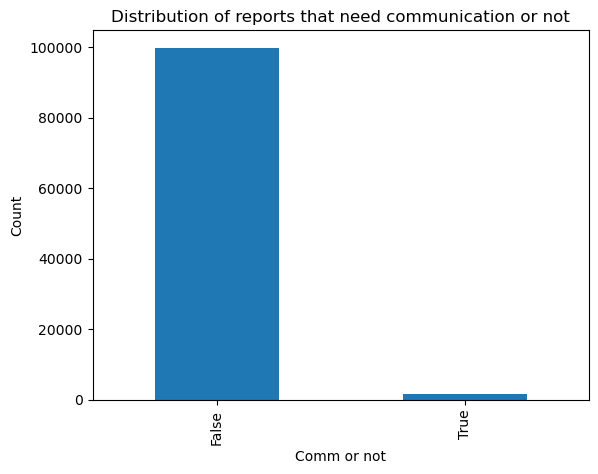

0.015054208963469373  of reports need further communication


In [6]:
data['label'] = data['Report Text'].str.contains('communicated|discussed|communicate|discuss')
value_counts = data['label'].value_counts()
print(value_counts)
value_counts.plot(kind='bar')
plt.xlabel('Comm or not')
plt.ylabel('Count')
plt.title('Distribution of reports that need communication or not')
plt.show()

dist = dict(value_counts)
percent = dist[True]/(dist[True]+dist[False])
print(percent,' of reports need further communication')

In [7]:
# Other factors - Age
print("Average patient age for those don't need further communication is:",np.mean(data[data['label']==False]['Patient Age']),
      "and average age for those that need communication is:",np.mean(data[data['label']==True]['Patient Age']))

Average patient age for those don't need further communication is: 44.7265097505033 and average age for those that need communication is: 46.53651376146789


In [8]:
# Other factors - Sex, Patient Status
sex = dict(data[data['label']==True]['Patient Sex'].value_counts())
status = dict(data[data['label']==True]['Patient Status'].value_counts())
print('Amon patients whose radiology report need further communication,', sex['Male']/263, 'are male, and',
     sex['Female']/263,'are female;',status['Inpatient']/263, 'are inpatient.')

Amon patients whose radiology report need further communication, 3.2395437262357416 are male, and 2.55893536121673 are female; 4.258555133079848 are inpatient.


## Preprocess

In [11]:
# functions from Adrian
def preprocess_findings(report_text):     
    findings_impression = re.search(r"((?<=\nFINDINGS\/IMPRESSION:|FINDINGS\/IMPRESSION:\n)(.|\n)*)", report_text)
    if findings_impression:
        findings_impression = findings_impression.group(0).split('"')[0]
        findings_impression = re.sub(r"(?=(Impression discussed|Further impression|Final impression|Attestation|Radiologist|Electronically|This change was|Report dictated))(.|\n)*", "", findings_impression)
        return findings_impression.strip()
    return 'None'

In [12]:
# functions from Adrian
def preprocess_dcm_path(i):   
    row = data.iloc[i]
    report_text = row['Report Text']

    accession_number = str(row['Accession Number'])
    patient_folder = f"{data_folder}/raw/{accession_number}" 
    
    patient_folder_files = os.listdir(patient_folder)

    for j in range(len(patient_folder_files)):
        study = patient_folder_files[j]
        if not os.path.isdir(f"{patient_folder}/{study}"):
            return 'None'
        image_files = os.listdir(f"{patient_folder}/{study}")
        ds = dcm.dcmread(f"{patient_folder}/{study}/{image_files[0]}")

        if 'Image Storage' in ds.SOPClassUID.name and 'ViewPosition' in ds and ds.ViewPosition != 'LL': 
            return f"{patient_folder}/{study}/{image_files[0]}"
    return 'None'

In [15]:
data_folder = '/mnt/sohn2022/UCSF_secure_cxr_data'

downloaded_data = pd.read_csv('/mnt/sohn2022/UCSF_secure_cxr_data/Secure_UCSF_CXR_01012022_to_02132023.csv')
downloaded_data['Downloaded'] = downloaded_data['Accession Number'].apply(str).isin(os.listdir(data_folder + '/raw'))
downloaded_data = downloaded_data[downloaded_data['Downloaded']]
downloaded_data = downloaded_data.drop(['Unnamed: 0'], axis=1)
len(downloaded_data)

99905

In [16]:
data = pd.read_csv('/mnt/sohn2022/UCSF_secure_cxr_data/Secure_UCSF_CXR_01012022_to_02132023.csv')
data['Downloaded'] = data['Accession Number'].apply(str).isin(os.listdir(data_folder + '/raw'))
data = data[data['Downloaded']]
data = data.drop(['Unnamed: 0'], axis=1)

print('Caption Preprocessing\n===============')
captions = []
for i in tqdm.tqdm(range(len(data))):
    captions.append(preprocess_findings(data['Report Text'].iloc[i]))
data['Caption'] = captions

# Limit normal findings/impression
# data = data[~data['Caption'].str.contains('No pleural effusion or pneumothorax')]
# data = data[~data['Caption'].str.contains('No pneumothorax')]
# data = data[~data['Caption'].str.contains('Lungs clear')][~data['Caption'].str.contains('Clear lungs')]
data = data[data['Caption'].apply(len) < 400].reset_index(drop=True)

print('DCM Path Preprocessing\n===============')
dcm_paths = []
for i in tqdm.tqdm(range(len(data))):
    dcm_paths.append(preprocess_dcm_path(i))
data['DCM Path'] = dcm_paths
data = data[data['Caption'] != 'None']
data = data[data['DCM Path'] != 'None']

data = data.reset_index(drop=True)
data.to_csv('data_processed.csv', index=False)

Caption Preprocessing


NameError: name 'tqdm' is not defined

In [ ]:
data = pd.read_csv('data_processed.csv').sample(frac=1)[:50000].reset_index()
data = data[data['Caption'].apply(lambda x: isinstance(x, str))]

In [ ]:
data

In [10]:
preprocess_dcm_path(0)

NameError: name 'data_folder' is not defined

## Preprocessing

In [9]:
# functions from Adrian
def preprocess_findings(report_text):     
    findings_impression = re.search(r"((?<=\nFINDINGS\/IMPRESSION:|FINDINGS\/IMPRESSION:\n)(.|\n)*)", report_text)
    if findings_impression:
        findings_impression = findings_impression.group(0).split('"')[0]
        findings_impression = re.sub(r"(?=(Impression discussed|Further impression|Final impression|Attestation|Radiologist|Electronically|This change was|Report dictated))(.|\n)*", "", findings_impression)
        return findings_impression.strip()
    return 'None'

In [10]:
data['Findings'] = data['Report Text'].apply(preprocess_findings)
data.head()

,Organization,Point of Care,Source System,Accession Number,Modality,Exam Code,Exam Description,CPT Code,Report Text,Is Stat,Patient Status,Patient Sex,Patient Age,label,Findings
0,MBXR1,RAD X-RAY MB,EPIC,10022207761,XR,DCHE2,XR CHEST 2 VIEWS PA AND LATERAL,71020,XR CHEST 2 VIEWS PA AND LATERAL 6/30/2022 11...,False,Emergency,Male,39.00,False,Clear lungs. No pleural effusion or pneumothor...
1,PDR11,RAD X-RAY PARN,EPIC,10022207760,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:53 PM\nHISTO...,False,Emergency,Male,41.00,False,Increased right greater than left opacities ma...
2,PDR9,RAD X-RAY PARN,EPIC,10022207745,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:36 PM\nHISTO...,False,Inpatient,Female,25.00,False,Endotracheal tube terminates approximately 5 c...
3,PDR9,RAD X-RAY PARN,EPIC,10022207747,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:26 PM\nHISTO...,False,Inpatient,Female,60.00,False,Right chest wall port appears unchanged.\nNo s...
4,MBP9,RAD X-RAY MB,EPIC,10022207748,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:21 PM\nINDIC...,False,Inpatient,Female,0.27,False,None


In [12]:
sample = data[data['label']==False].sample(500)
data = pd.concat([sample,data[data['label']==True]])
data

,Organization,Point of Care,Source System,Accession Number,Modality,Exam Code,Exam Description,CPT Code,Report Text,Is Stat,Patient Status,Patient Sex,Patient Age,label,Findings
11498,E01,RAD X-RAY PARN,EPIC,10021833556,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 2/11/2022 11...,False,Emergency,Female,78.0,False,Clear lungs. No pleural effusion or pneumothor...
10132,ZP1,RAD FLUOROSCOPY MZ,EPIC,10022098090,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 5/19/2022 11:01 AM\nHISTO...,False,Outpatient,Male,75.0,False,Increased streaky bibasilar opacities may refl...
16438,PDR9,RAD X-RAY PARN,EPIC,10021775878,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/23/2022 3:...,False,Inpatient,Male,70.0,False,Moderate left pleural effusion with adjacent h...
3007,M02,RAD X-RAY PARN,EPIC,10022727325,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 12/19/2022 1:20 PM\nHISTO...,False,Outpatient,Male,78.0,False,Slightly decreased trace left apical pneumotho...
20139,PDR7,RAD X-RAY PARN,EPIC,10021989800,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 4/10/2022 8:20 AM\nHISTOR...,False,Inpatient,Female,57.0,False,"Increased patchy opacity right lower lung, pos..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17856,PDR8,RAD X-RAY PARN,EPIC,10021760521,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/17/2022 5:...,False,Inpatient,Male,68.0,True,Interval removal of right thoracostomy tube. U...
17866,PDR9,RAD X-RAY PARN,EPIC,10021760501,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/17/2022 4:...,False,Inpatient,Female,24.0,True,Interval removal of endotracheal tube with oth...
18164,PDR7,RAD X-RAY PARN,EPIC,10021759316,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/15/2022 1:...,False,Inpatient,Female,67.0,True,"There appears to be a roughly 1.3 cm thin, lin..."
18847,PDR6,RAD X-RAY PARN,EPIC,10021752132,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/12/2022 6:...,False,Inpatient,Male,61.0,True,Postsurgical changes of recent hiatal hernia r...


## Preprocess
Word tokenization, Stopword removal, word normalization, negation

In [24]:
import nltk
from nltk.corpus import treebank 
from nltk.tree import Tree
import string
import re
import os
import argparse

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/bdrad/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def tokenization(text):
    text = text.strip()
    text = re.split('\W+', text)
    return text

def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text

def clean_text(text):
    text = remove_punct(text)
    text = tokenization(text)
    text = remove_stopwords(text)
    return text

In [30]:
data['Findings'] = data['Findings'].apply(clean_text)
data

,Organization,Point of Care,Source System,Accession Number,Modality,Exam Code,Exam Description,CPT Code,Report Text,Is Stat,Patient Status,Patient Sex,Patient Age,label,Findings
11498,E01,RAD X-RAY PARN,EPIC,10021833556,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 2/11/2022 11...,False,Emergency,Female,78.0,False,[clearlungsnopleuraleffusionpneumothoraxstable...
10132,ZP1,RAD FLUOROSCOPY MZ,EPIC,10022098090,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 5/19/2022 11:01 AM\nHISTO...,False,Outpatient,Male,75.0,False,[increasedstreakybibasilaropacitiesmayreflecta...
16438,PDR9,RAD X-RAY PARN,EPIC,10021775878,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/23/2022 3:...,False,Inpatient,Male,70.0,False,[moderateleftpleuraleffusionadjacenthazyopacit...
3007,M02,RAD X-RAY PARN,EPIC,10022727325,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 12/19/2022 1:20 PM\nHISTO...,False,Outpatient,Male,78.0,False,[slightlydecreasedtraceleftapicalpneumothoraxo...
20139,PDR7,RAD X-RAY PARN,EPIC,10021989800,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 4/10/2022 8:20 AM\nHISTOR...,False,Inpatient,Female,57.0,False,[increasedpatchyopacityrightlowerlungpossiblya...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17856,PDR8,RAD X-RAY PARN,EPIC,10021760521,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/17/2022 5:...,False,Inpatient,Male,68.0,True,[intervalremovalrightthoracostomytubeunchanged...
17866,PDR9,RAD X-RAY PARN,EPIC,10021760501,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/17/2022 4:...,False,Inpatient,Female,24.0,True,[intervalremovalendotrachealtubeotherwiseuncha...
18164,PDR7,RAD X-RAY PARN,EPIC,10021759316,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/15/2022 1:...,False,Inpatient,Female,67.0,True,[thereappearsroughlycmthinlinearopacityupperme...
18847,PDR6,RAD X-RAY PARN,EPIC,10021752132,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/12/2022 6:...,False,Inpatient,Male,61.0,True,[postsurgicalchangesrecenthiatalherniarepairne...


## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# fix seed for reproducibility
np.random.seed(2023)

# split the dataset depending on whether we need a validation set
def split(reports_df, val=False):
    train, test = train_test_split(reports_df, test_size = 0.2, shuffle=True)
    if val:
        train, validation = train_test_split(train, test_size = 0.1, shuffle=True)
        return train, validation, test
    else:
        return train, test

train,test = split(data,val=False)

## Naive Bayes

In [ ]:
def sparse_vector_create(tuple_list,vocab_len):
    #tuple_list will have data structure akin to gensim dictionary doc2bow output 
    sparse_vector = np.zeros(vocab_len)
    for id,freq in tuple_list:
        sparse_vector[id] = freq
    return sparse_vector

def sparse_vector_generator(tokens,vocab_dict,vocab_len):
    for token in tokens:
        yield sparse_vector_create(vocab_dict.doc2bow(token),vocab_len)

# recreate generator object to reset it , otherwise will output empty result
train_tokens = token_generator(train['Findings'].to_list())
x_train_sparse = [sparse_vector for sparse_vector in sparse_vector_generator(train_tokens,train_vocab_dict,len(train_vocab_dict))]

In [ ]:
from sklearn import naive_bayes

nb_classifier = naive_bayes.MultinomialNB(alpha=1.0)

nb_classifier.fit(x_train_sparse,y_train)

In [ ]:
test_tokens = token_generator(test_text)
nb_predictions = list()

for token in test_tokens:
    test_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(token),len(train_vocab_dict))
    nb_predictions.append(nb_classifier.predict(test_sparse_vector.reshape(1,-1))[0])

## SVM

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf=True, smooth_idf = True,sublinear_tf = True)
tfidf.fit(x_train_sparse)
x_train_tfidf= tfidf.transform(x_train_sparse)

NameError: name 'x_train_sparse' is not defined

In [ ]:
from sklearn import svm

SVM = svm.SVC(C=1.0,kernel ='linear')
SVM.fit(x_train_tfidf,y_train)

In [ ]:
test_tokens = token_generator(test_text)
svm_predictions = list()

for token in test_tokens:
    test_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(token),len(train_vocab_dict))
    x_test_tfidf = tfidf.transform(test_sparse_vector.reshape(1,-1))
    svm_predictions.append(SVM.predict(x_test_tfidf)[0])